In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import diffusionstuff6 as ds
from copy import copy as dup
from scipy.integrate import odeint
from matplotlib import rcParams
from test_ice_model_module import multiple_test_avg_time

In [2]:
#Meta testing parameters
n_tests = 50

In [3]:
# Graphics parameters
%matplotlib widget
ticklabelsize = 15
fontsize = 15
linewidth = 2
fignum = 0

In [4]:
#Parameters for the model
nx = 500 # Number of points in simulation box
xmax = 50
x = np.linspace(0, xmax, nx)
boxpoints = len(x)
deltaX = x[1]-x[0]

niter = 1 # Number of iterations to calculate Nliq from Ntot
Nbar = 1.0 # new Nbar from VMD, 260K
Nstar = .9/(2*np.pi)
Nice = np.zeros(boxpoints)+1 

In [5]:
# Timing Initialize as a pre-equilibrated layer of liquid over ice
func = ds.getNliq_array
args = (Nice,Nstar,Nbar,niter)
multiple_test_avg_time(func, args, n_tests)
Fliq = func(*args)

Time to run getNliq_array on average for 50 tests:  0.0 seconds


In [6]:
# Lay out the system
Ntot = Fliq + Nice
nmid = int(nx/2)
nquart = int(nx/4)
xmid = max(x)/2
xmax = x[nx-1]
Nice_start = Nice[0]

Niceoffset = ds.getNiceoffset(Nbar, Nstar, 1, 0) # Should be close to .75; not used if D=const

In [7]:
#Test diffusion functions setup
# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)

# Diffusion coefficient
D = 0.02e-2 # micrometers^2/microsecond

# Time steps
dtmaxtimefactor = 10
dtmaxtimefactor = 50
dtmax = deltaX**2/D
deltaT = dtmax/dtmaxtimefactor

# Deposition rate
nu_kin = 49 # microns/second
deprate = nu_kin/umpersec_over_mlyperus # monolayers per microsecond
deprate_times_deltaT = deprate * deltaT

# Supersaturation
sigma0 = 0.19
sigmastepmax = 0.20 # Must be bigger than sigma0 to get growth
center_reduction = 0.25 # In percent
c_r = center_reduction/100

# Diffusion coefficient scaled for this time-step and space-step
DoverdeltaX2 = D/deltaX**2

In [8]:
#Test sigmastep function performance
func = ds.getsigmastep
method ='sinusoid'
args = (x,xmax,center_reduction,sigmastepmax, method)
multiple_test_avg_time(func, args, n_tests)

Time to run getsigmastep on average for 50 tests:  0.011770691871643067 seconds


0.011770691871643067

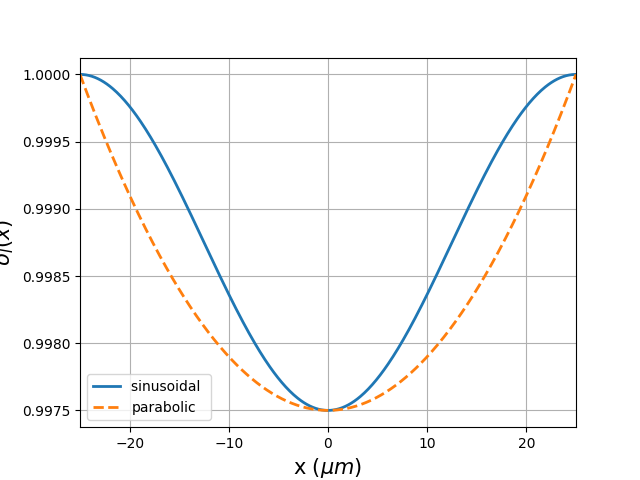

In [9]:
# Gets the function sigma(x)
sigmastep_sinusoid = ds.getsigmastep(x,xmax,center_reduction,sigmastepmax,method='sinusoid')
sigmastep_parabolic = ds.getsigmastep(x,xmax,center_reduction,sigmastepmax,method='parabolic')
sigmastepstyle = 'sinusoid'
if sigmastepstyle=='sinusoid':
    sigmastep = sigmastep_sinusoid
elif sigmastepstyle=='parabolic':
    sigmastep = sigmastep_parabolic
else:
    print('bad choice')

# Graph sigma(x)
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid,sigmastep_sinusoid/sigmastepmax, \
         x-xmid, sigmastep_parabolic/sigmastepmax, '--',lw=linewidth)
plt.xlim([-xmid,xmid])
plt.legend(['sinusoidal ', 'parabolic'])
plt.xlabel(r'x ($\mu m$)',fontsize=fontsize)
plt.ylabel(r'$\sigma_I(x) $',fontsize=fontsize)
plt.grid('on')

In [10]:
# These are run control parameters

# Flag for explicit updating Fliq(Ntot) every step
updatingFliq = True

# Set up a maximum number of iterations or layers
uselayers = True

# 0D run
if uselayers:
    layermax_0D = 4
else:
    countermax_0D = 100

# 1D run 
if uselayers:
    layermax_1D = 10
else:
    countermax_1D = 15000

In [11]:
# This is the 0-d run
timelist = []
for run in range(n_tests):
    starttime = time.time()
    # Bundle parameters for ODE solver
    params = np.array([Nbar, Nstar, sigmastepmax, sigma0, deprate])

    # Initial conditions for ODE solver
    y0 = [Nbar, 0.0]
    ylast = dup(y0)

    # Time steps
    t0 = 0.0
    ttot = 0.0
    tinterval = [t0, deltaT]

    # Initialize the keeper arrays
    tkeep_0D = [t0]
    ykeep_0D = [y0]
    tlast = dup(t0)
    Nicelast0 = 0.0
    Ntotlast0 = 0.0
    Nicelast_start = 0.0
    Ntotlast_start = 0.0

    # Call the ODE solver
    counter = 0
    layer = 0
    while True:
        
        # Integrate up to next time step
        y = odeint(ds.f0d, ylast, tinterval, args=(params,niter))
        ylast = list(y[1,:])
        tlast += deltaT
        
        # Stuff into keeper arrays
        ykeep_0D.append(ylast)
        tkeep_0D.append(tlast)
        
        # Make some local copies, with possible updates to Fliq
        Fliqlast, Ntotlast = ylast

        if updatingFliq:
            Fliqlast = ds.getNliq(Ntotlast,Nstar,Nbar,niter) # This updates Fliqlast and ylast!
            ykeep_0D[counter][0] = Fliqlast # Saves the updated Fliq for this step
        Nicelast = Ntotlast - Fliqlast
        Nicelast0 = dup(Nicelast)
        Ntotlast0 = dup(Ntotlast)
        
        # Update counters and see whether to break
        counter += 1
        layer = dup(Ntotlast0) 
        if uselayers:
            if layer > layermax_0D-1:
                break
        else:
            if counter > countermax_0D-1:
                break
        
    # Convert results to a numpy array
    ykeep_0Darr = np.array(ykeep_0D, np.float64)
    tkeep_0Darr = np.array(tkeep_0D, np.float64)
    timelist.append(time.time()-starttime)

print("Average time to run for ", n_tests, " runs: ", np.mean(timelist), " seconds")

Average time to run for  50  runs:  0.014012718200683593  seconds


0-D Modeled growth rate, um/s 1.8991811295891783
0-D Modeled growth rate, ml/us 0.006330603765297261
0-D Modeled alpha 0.19379399281522228


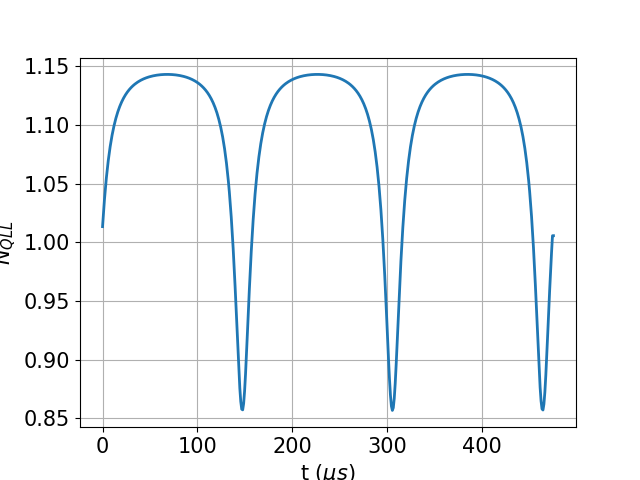

In [12]:
# Plot results of zero-d run
fignum +=1
plt.figure(fignum)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0D,ykeep_0Darr[:,0],lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.grid('on')

# Growth statistics
delta_Ntot_0d = Ntotlast0-Ntotlast_start
growthrate_0d_mlyperus = delta_Ntot_0d/tlast # monolayer/us
growthrate_0d = growthrate_0d_mlyperus*umpersec_over_mlyperus # um/sec
print( "0-D Modeled growth rate, um/s", growthrate_0d)
print( "0-D Modeled growth rate, ml/us", growthrate_0d_mlyperus)
alpha_0d = growthrate_0d/nu_kin/sigmastepmax
print( "0-D Modeled alpha", alpha_0d)
timelist.append(time.time()-starttime)

In [13]:
#Parameters for 1-D run 
L = xmax/2; print(L) # micrometers
c_r = center_reduction / 100; print(c_r) # dimensionless
nu_kin_ml = deprate; print(nu_kin_ml) # monolayers per microsecond
sigma_I = sigmastepmax; print(sigma_I) # dimensionless
print(D) # D is in micrometers^2/microsecond
M = np.array([.0027, .0025])
B = np.array([2.9, 1.59])
beta = np.array([0.65, 0.65])
xfactor = nu_kin_ml*L**2*c_r**beta*sigma_I/D
NSS = M*xfactor + B
print('Nss predicted')
print('sinusoid:', NSS[0])
print('paraboloic:', NSS[1])

25.0
0.0025
0.16333333333333333
0.2
0.0002
Nss predicted
sinusoid: 8.510216387742963
paraboloic: 6.784644803465706


In [16]:
timelist = []
for run in range(n_tests):
    # Timing
    sec1 = time.time()
    #Nbar, Nstar, niter, sigmastep, sigma0, deprate, DoverdeltaX2, nx = params #original params
    # Bundle parameters for ODE solver
    float_params = np.array([Nbar, Nstar, sigma0, deprate, DoverdeltaX2])
    int_params = np.array([niter,nx])

    # Initial conditions for ODE solver
    y0 = list([Fliq,Ntot])
    ylast = dup(y0)

    # Time steps
    t0 = 0.0
    tlast = dup(t0)
    ttot = 0.0
    tinterval = [t0, deltaT]

    # Initialize the keeper arrays
    tkeep = [t0]
    Nicekeep = [dup(Nice)]
    Ntotkeep = [dup(Ntot)]
    Fliqkeep = [dup(Fliq)]
    fluxderivskeep = []

    # Call the ODE solver
    Nice0_start = Nice[0]
    Nice0 = Nice[0]
    Ntot0_start = Ntot[0]
    Ntot0 = Ntot[0]
    updatingFliq = True
    counter = 0
    lastlayer = 0
    lastdiff = 0
    while True:
        # Integrate up to next time step
        y = odeint(ds.f1d, np.reshape(ylast,2*nx), tinterval, args=(float_params,int_params,sigmastep),rtol=1e-12)
        
        ylast = np.reshape(y[1],(2,nx))
        tlast += deltaT
        counter += 1
            
        # Make some local copies, with possible updates to Fliq
        Fliq, Ntot = ylast
        if updatingFliq:
            Fliq = ds.getNliq_array(Ntot,Nstar,Nbar,niter) # This updates to remove any drift
            ylast[0] = Fliq
        Nice = Ntot - Fliq
        Nice0 = Nice[0]
        Ntot0 = Ntot[0]
        ttot += deltaT
        
        # Update counters and see whether to break
        layer = Ntot0-Ntot0_start
        if (layer-lastlayer) > 0:
            minpoint = min(Nice)
            maxpoint = max(Nice)
            print(counter-1, lastlayer, maxpoint-minpoint, maxpoint-minpoint-lastdiff)
            lastdiff = maxpoint-minpoint
            lastlayer += 1
        if uselayers:
            if layer > layermax_1D-1:
                print('breaking because reached max number of layers')
                break
        else:
            if counter > countermax_1D-1:
                print('breaking because reached max number of iterations')
                break
    timelist.append(time.time()-sec1)
print("Took ", np.average(timelist), " seconds (on average for ", n_tests," runs) to run 1d model")

0 0 2.5080546457223463e-05 2.5080546457223463e-05
157 1 0.007224137403087472 0.007199056856630248
315 2 0.02745711704296161 0.020232979639874138
472 3 0.13809035034289074 0.11063323329992913
630 4 0.3070866978557234 0.16899634751283266
787 5 0.4933640469471223 0.18627734909139892
945 6 0.5938442559633001 0.10048020901617782
1102 7 0.6746181633205692 0.08077390735726908
1260 8 0.7190664149416524 0.044448251621083124
1417 9 0.7574061421767997 0.038339727235147336
breaking because reached max number of layers
0 0 0.7520297401997826 0.7520297401997826
157 1 0.781276952566401 0.029247212366618314
315 2 0.8004469570077521 0.019170004441351196
472 3 0.818170272378488 0.017723315370735904
630 4 0.8310315148449945 0.01286124246650644
787 5 0.8431076614849182 0.012076146639923735
945 6 0.8526872244031694 0.009579562918251128
1102 7 0.8616889950657409 0.009001770662571573
1260 8 0.8694144290009973 0.007725433935256376
1417 9 0.8766371345621877 0.007222705561190423
breaking because reached max num